In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
plt.style.use('fivethirtyeight')

In [2]:
#sse as loss function
def sse(x,y):
    z=np.square(x-y)
    ans = np.sum(z)
    return np.sqrt(ans)

# plot cdf
def get_cdf_data(x):
    total = x.shape[0]
    unq, cnts = np.unique(x, return_counts=True)    
    cnts_arr = np.asarray(cnts)
    cdf_val = np.divide(cnts_arr, total)
    cdf_val = np.cumsum(cdf_val)    
    return cdf_val, unq

def get_hExpo_cdf(lmbds,p,unq):
    lmbdsT = np.transpose(lmbds)
    tmp1 = np.matmul(unq,lmbdsT)
    tmp1 = -1*tmp1        
    tmp2 = np.exp(tmp1)        
    tmp3 = np.matmul(tmp2, p)    
    hExpo_cdf = 1-tmp3
    return hExpo_cdf

def ks_stat(x,y):
    z = np.absolute(y-x)
    return np.amax(z), np.argmax(z)

In [3]:
def calcLoss(x, lmbds, p, H):
    lmbdsT = np.transpose(lmbds)
    lX = np.matmul(x, lmbdsT)
    logLmbds = np.transpose(np.log(lmbds))
    logP = np.transpose(np.log(p))
    tmp1 = lX - logLmbds
    tmp2 = tmp1 - logP
    tmp3 = H*tmp2
    L = np.sum(H*tmp2)
    return L

#normalization
def normalize(x):
    xmax = np.amax(x)
    xmin = np.amin(x)
    diff = xmax - xmin
    x = x - xmin
    x = x/diff
    return x

#fit trace data to a hyperexponential distribution using Expectation Maximization
def calc_EM(x, k):
        
    lm=[]
    
    #generate k random values
    for i in range(0, k):
            lm.append(rnd.randint(1,10))
    lmbds = np.array(lm)
    lmbds = np.reshape(lmbds, (lmbds.shape[0],1))

    #generate k random probabilities
    prob=[]
    for i in range(0, k):
            prob.append(rnd.randint(1,10))

    p = np.array(prob)
    p = p/np.sum(p)
    p = np.reshape(p, (p.shape[0],1))     
    loss = []    
    L = np.inf

    while(True):

        ###################expectation step#########################
        lmbdsT = np.transpose(lmbds)
        t1 = np.matmul(x,lmbdsT)
        t1 = -1*t1
        t2 = np.exp(t1)
        pL = p*lmbds
        pLT = np.transpose(pL)
        t3 = pLT*t2
        t4 = np.sum(t3, axis = 1, keepdims = True)
        H = t3/t4

        ########################mxmztn step##########################
        lmbdsOld = np.copy(lmbds)
        sumHik = np.sum(H, axis = 0, keepdims = True)
        Hx = H*x
        sumHx = np.sum(Hx, axis = 0, keepdims = True)
        lmbdsNew = sumHik/sumHx
        lmbds = np.transpose(lmbdsNew)
        K = np.sum(sumHik, axis = 1 )    
        pOld = np.copy(p)
        p = np.transpose(sumHik/K)    

        ###########################calcLoss##########################
        lOld = L
        L = calcLoss(x, lmbds, p, H)
        loss.append(L)
        print(L)
        if(L > lOld):
            break
    return lmbds, p, L

In [4]:
def plotCdf(l1, nm1, l2, nm2, lx, figName ):
    %matplotlib inline
    plt.figure(figsize=(8,8),dpi=100)
    plt.title(figName)        
    plt.xlabel('Data Points', fontsize=18)
    plt.ylabel('Probabilities', fontsize=18)    
    plt.plot(lx, l1, label=nm1)
    plt.plot(lx, l2, label=nm2)
    plt.legend()
    plt.savefig(figName,bbox_inches="tight")    
    

In [6]:
#read traces
file_name = "1100-1149_readlink_sorted.txt"
df = pd.read_csv('./data/1100-1149_readlink_sorted.txt', header = None)

-141676.28443
-142013.179266
-144319.003136
-147607.473442
-149808.871237
-151085.963766
-151955.679664
-152691.656381
-153396.44554
-154098.935701
-154800.941861
-155495.142222
-156171.526568
-156819.818787
-157430.600224
-157996.00772
-158510.223694
-158969.767804
-159373.558598
-159722.737064
-160020.288591
-160270.538593
-160478.613543
-160649.949145
-160789.898964
-160903.463452
-160995.132384
-161068.818401
-161127.854673
-161175.032129
-161212.657225
-161242.617144
-161266.444371
-161285.376202
-161300.407221
-161312.334218
-161321.793875
-161329.293919
-161335.238616
-161339.949463
-161343.6819
-161346.638726
-161348.980861
-161350.835932
-161352.305127
-161353.46865
-161354.390059
-161355.11971
-161355.697495
-161356.155013
-161356.517291
-161356.804152
-161357.031294
-161357.211146
-161357.353554
-161357.466313
-161357.555595
-161357.626288
-161357.682262
-161357.726582
-161357.761674
-161357.78946
-161357.81146
-161357.828879
-161357.842672
-161357.853593
-161357.86224
-1613

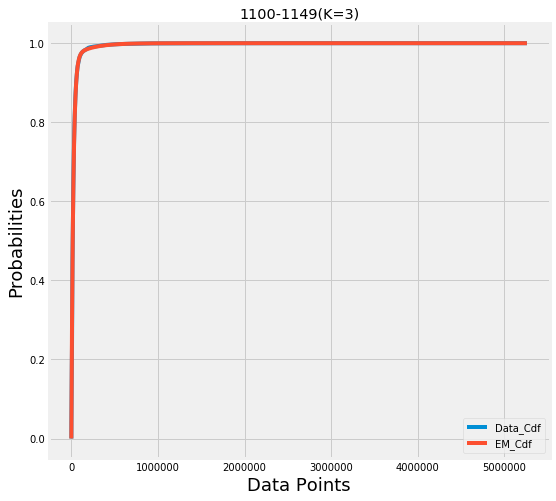

In [7]:
x  = df.as_matrix()
cdf_vals, unq = get_cdf_data(x)
unq = np.reshape(unq, (unq.shape[0],1))
cdf_vals = np.reshape(cdf_vals, (cdf_vals.shape[0],1))
x = normalize(x)
unq1 = np.copy(unq)
unq1 = normalize(unq1)
lmbdsFinal, pFinal, loss = calc_EM(x,3)
hExpo_cdf = get_hExpo_cdf(lmbdsFinal, pFinal, unq1)
val,j = ks_stat(hExpo_cdf, cdf_vals)
#plot cdfs
plotCdf(cdf_vals, "Data_Cdf", hExpo_cdf, "EM_Cdf", unq, "1100-1149(K=3)")
print("Final lambdas:", list(np.transpose(lmbdsFinal)))
print("Final probabilities:", list(np.transpose(pFinal)))
print("KS_Value:", val,"at",unq[j])

In [8]:
#generate k random values
k=2
lm=[]
for i in range(0, k):
        lm.append(rnd.randint(1,10))
lmbds = np.array([0.001,0.1])
lmbds = np.reshape(lmbds, (lmbds.shape[0],1))
#generate k random probabilities
prob=[]
for i in range(0, k):
        prob.append(rnd.randint(1,10))
p = np.array(prob)
p = p/np.sum(p)
p = np.reshape(p, (p.shape[0],1))

print("initial values")
print("lambda:", list(np.transpose(lmbds)))
print("probabilities:", list(np.transpose(p)))

hExpo_cdf = get_hExpo_cdf(lmbds, p, unq)
val,j = ks_stat(hExpo_cdf, cdf_vals)
print("KS_Value:", val,"at",unq[j])

initial values
lambda: [array([ 0.001,  0.1  ])]
probabilities: [array([ 0.36363636,  0.63636364])]
[[ -1.34000000e-01  -1.34000000e+01]
 [ -1.89000000e-01  -1.89000000e+01]
 [ -2.40000000e-01  -2.40000000e+01]
 ..., 
 [ -2.19623200e+03  -2.19623200e+05]
 [ -2.92502300e+03  -2.92502300e+05]
 [ -5.26081200e+03  -5.26081200e+05]]
[[  8.74590065e-01   1.51514411e-06]
 [  8.27786507e-01   6.19204768e-09]
 [  7.86627861e-01   3.77513454e-11]
 ..., 
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]]
[[ 0.31803371]
 [ 0.30101328]
 [ 0.28604649]
 ..., 
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
KS_Value: 0.831668294785 at [ 2100.]


In [9]:
#read traces
file_name = "sorted_sample.txt"
df = pd.read_csv('./data/sorted_sample.txt', header = None)

-162906.691203
-173517.294997
-226120.657222
-287147.396041
-317979.253752
-324093.373435
-325442.695793
-326079.446014
-326499.172582
-326783.851526
-326972.667294
-327093.608095
-327166.799699
-327206.402342
-327222.277908
-327221.291582
[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -0.00000000e+00
   -0.00000000e+00  -0.00000000e+00]
 [ -3.24031552e-05  -3.24031552e-05  -1.75424226e-03 ...,  -1.22096543e-05
   -2.20729982e-05  -2.20729982e-05]
 [ -6.48063105e-05  -6.48063105e-05  -3.50848453e-03 ...,  -2.44193086e-05
   -4.41459964e-05  -4.41459964e-05]
 ..., 
 [ -5.83006318e+01  -5.83006318e+01  -3.15628005e+03 ...,  -2.19679397e+01
   -3.97143343e+01  -3.97143343e+01]
 [ -6.11985108e+01  -6.11985108e+01  -3.31316544e+03 ...,  -2.30598735e+01
   -4.16883667e+01  -4.16883667e+01]
 [ -1.05055987e+02  -1.05055987e+02  -5.68752182e+03 ...,  -3.95855673e+01
   -7.15640373e+01  -7.15640373e+01]]
[[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1

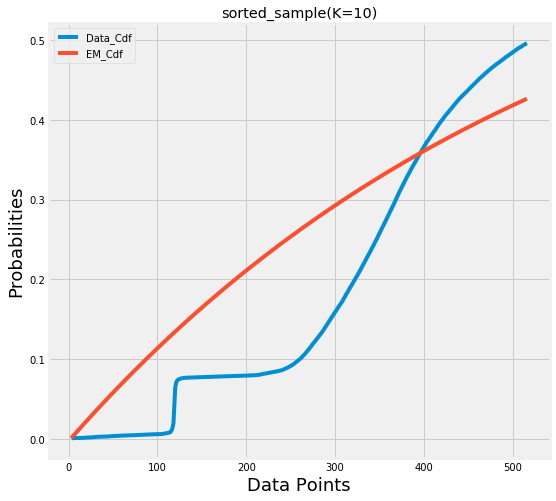

In [10]:
x  = df.as_matrix()
cdf_vals, unq = get_cdf_data(x)
unq = np.reshape(unq, (unq.shape[0],1))
cdf_vals = np.reshape(cdf_vals, (cdf_vals.shape[0],1))
x = normalize(x)
unq1 = np.copy(unq)
unq1 = normalize(unq1)
lmbdsFinal, pFinal, loss = calc_EM(x,10)
hExpo_cdf = get_hExpo_cdf(lmbdsFinal, pFinal, unq1)
val,j = ks_stat(hExpo_cdf, cdf_vals)
#plot cdfs
plotCdf(cdf_vals[1:500], "Data_Cdf", hExpo_cdf[1:500], "EM_Cdf", unq[1:500], "sorted_sample(K=10)")
print("Final lambdas:", list(np.transpose(lmbdsFinal)))
print("Final probabilities:", list(np.transpose(pFinal)))
print("Loss:", loss)
print("KS_Value:", val,"at",unq[j])